<a href="https://colab.research.google.com/github/rjrizani/LLMs-in-Web-Scraping/blob/main/No_Code%2C_Any_Data_Using_LLMs_in_Zyte_API_and_Scrapy_Cloud_to_extract_data_from_the_web.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Extract Any Data with No-Code Using an LLM in Zyte API and Scrapy Cloud

This notebook covers everything you need to know about web data extraction using LLMs in Zyte API and Scrapy Cloud to extract any kind of data without writing a single line of code.

We will also show why and how we approached the challenge of using an LLM to create this feature.

## Standard Schemas: The Core

At Zyte, our [Standard Schemas](https://docs.zyte.com/zyte-data/schemas/index.html) form the core of our data extraction process. These schemas define what our internal ML models deliver in terms of data and format, ensuring that the information we extract will always be standardized within these bounds.

## Machine Learning models behind the Standard Schemas

Behind the Standard Schemas there are ML models that have been trained and refined to extract correct data following a set of given guidelines.

Generally speaking, whenever we want to add a new field to extract (attribute) in one of the standard schemas, a extensive process has to happen:

- data annotation and validation
- train the model
- validate the results
- (maybe iterate)

So, the Standard Schemas have been more or less static over time.



## The Product Standard Schema

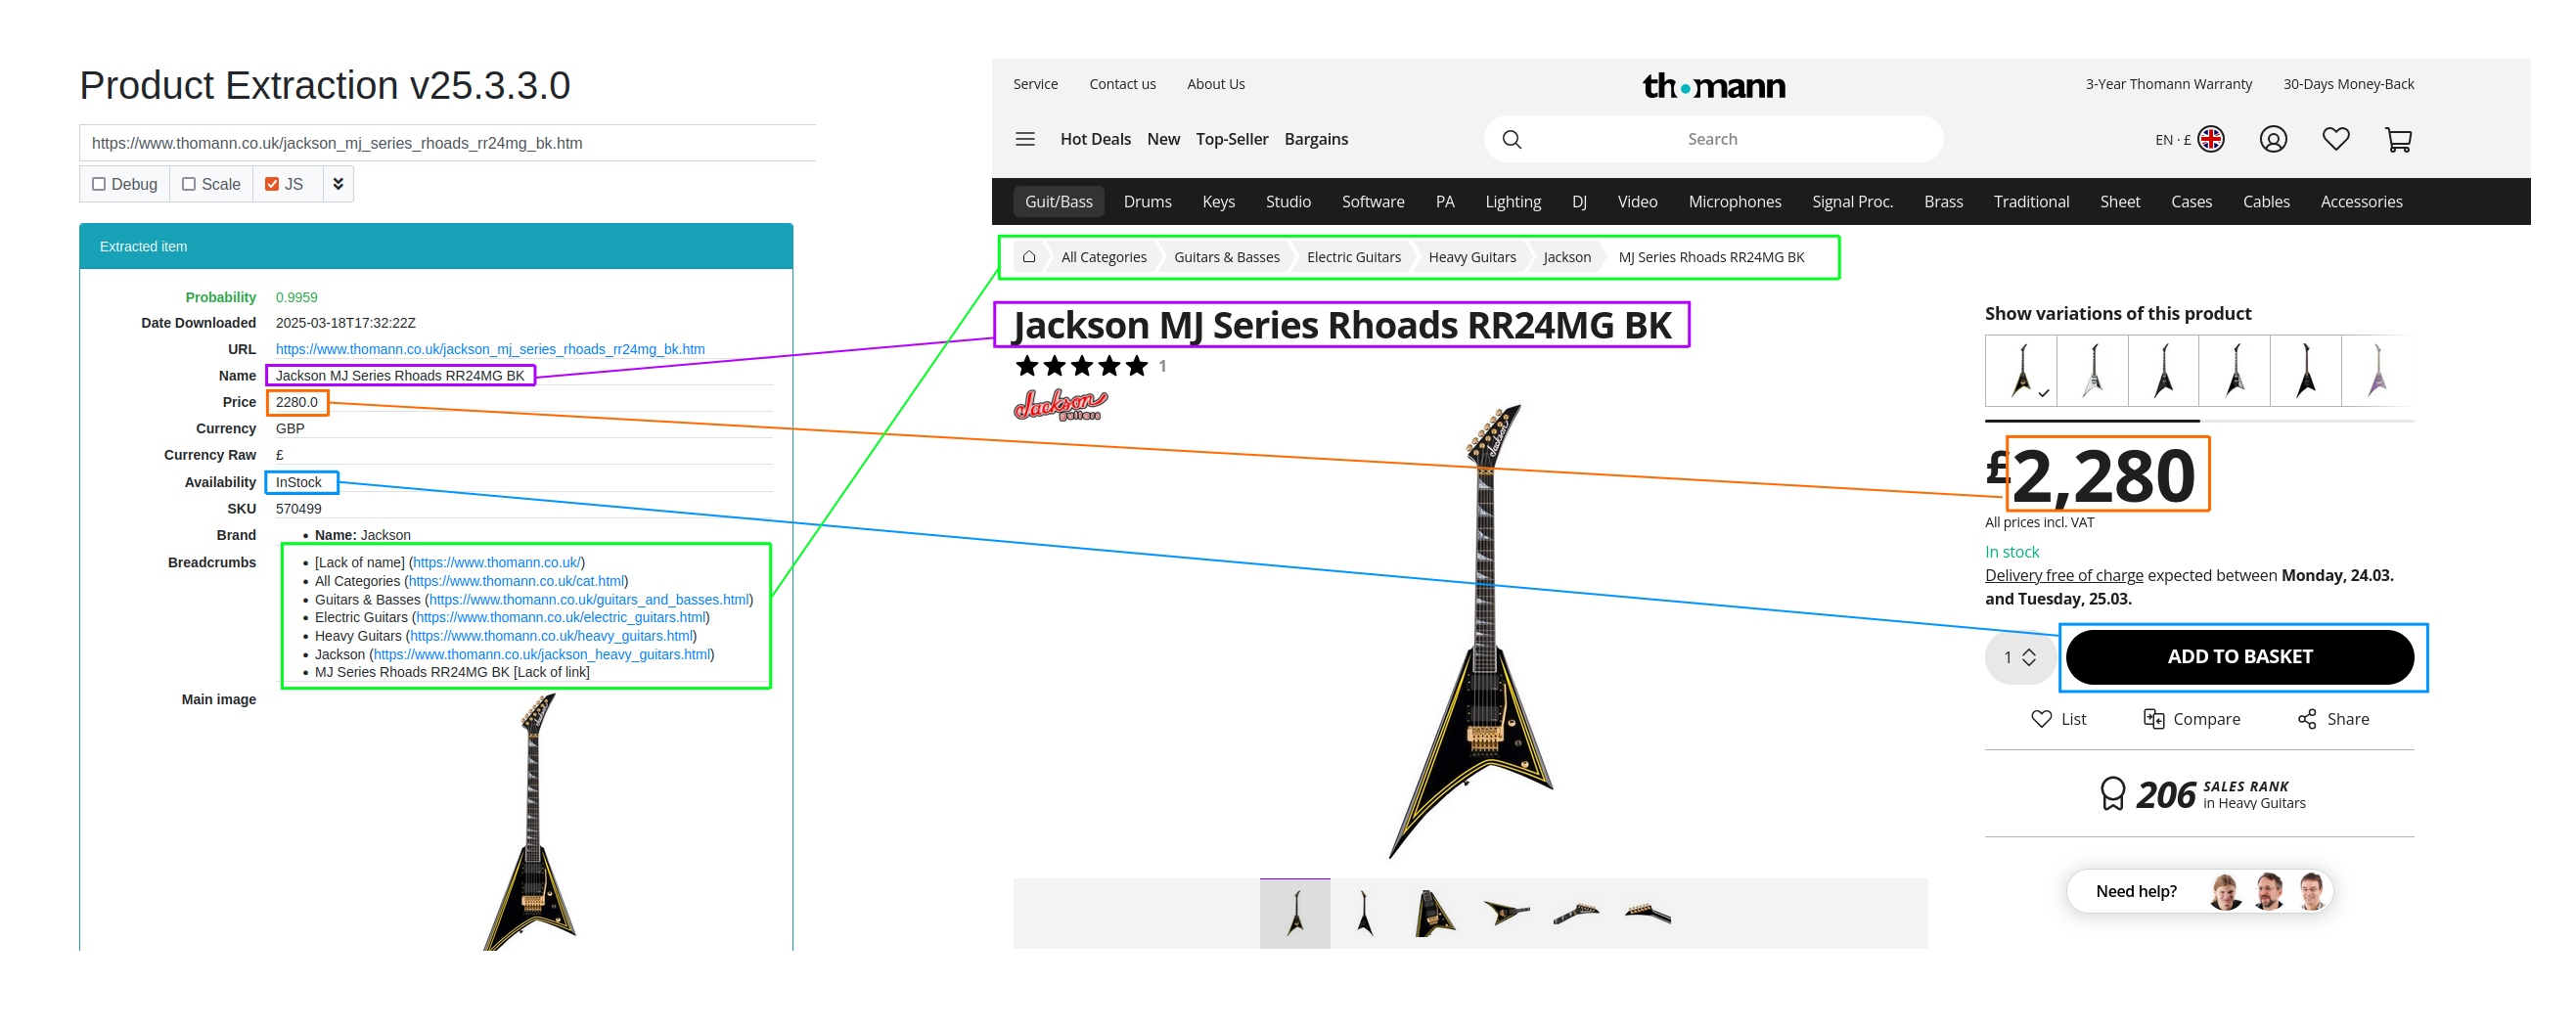


For example, for e-commerce data, our [Product Standard Schema](https://docs.zyte.com/zyte-data/schemas/product/1.0.html) gathers all the essential details: `price`, `regularPrice`, `availability`, `color`, `currency`, etc.


➡️ Let's extract from this example page the data using the Product Standard Schema and Zyte API client for python.

In [1]:
#@title Install dependencies
!pip install -qqq zyte-api==0.7.0 nest-asyncio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.4/101.4 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 29.6 MB/s eta 0:00:00


In [2]:
# Imports
from google.colab import userdata
import nest_asyncio
from zyte_api import AsyncZyteAPI

# This is to work with async within a notebook
nest_asyncio.apply()

# Create the Zyte API Client
ZYTE_API_KEY = userdata.get('ZYTE_API_KEY')
print(ZYTE_API_KEY)
client = AsyncZyteAPI(api_key=ZYTE_API_KEY)


# Extract data for Product (Product Standard Schema)
url = "https://www.thomann.co.uk/jackson_mj_series_rhoads_rr24mg_bk.htm"
response = await client.get(
    {
        "url": url,
        "browserHtml": True,
        "product": True,
        "productOptions": {
            "extractFrom": "browserHtml",
        }
    }
)

1234


RequestError: RequestError: 401, message=Unauthorized, headers=<CIMultiDictProxy('Date': 'Tue, 08 Apr 2025 03:21:50 GMT', 'Content-Type': 'application/problem+json', 'Content-Length': '150', 'Connection': 'close', 'WWW-Authenticate': 'Basic realm="Zyte API"', 'Request-Id': 'ee2fe1d9788bbf3eb41053185e7476da', 'Vary': 'Accept-Encoding', 'Strict-Transport-Security': 'max-age=31536000; includeSubDomains; preload', 'Access-Control-Allow-Credentials': 'true', 'Access-Control-Expose-Headers': '*, X-Project-Key', 'Access-Control-Allow-Methods': 'GET, PUT, POST, DELETE, PATCH, OPTIONS', 'Access-Control-Allow-Headers': 'DNT, Keep-Alive, User-Agent, X-Requested-With, If-Modified-Since, Cache-Control, Content-Type, Range, Authorization, X-Project-Key', 'Access-Control-Max-Age': '1728000')>, body=b'{"type":"/auth/key-not-found","title":"Authentication Key Not Found","status":401,"detail":"The authentication key is not valid or can\'t be matched."}', request_id=ee2fe1d9788bbf3eb41053185e7476da

In [ ]:
# Check the data that extracted
import json

print(json.dumps(response['product'], ensure_ascii=False, indent=4))

{
    "name": "Jackson MJ Series Rhoads RR24MG BK",
    "price": "2288.0",
    "currency": "GBP",
    "currencyRaw": "£",
    "availability": "InStock",
    "sku": "570499",
    "brand": {
        "name": "Jackson"
    },
    "breadcrumbs": [
        {
            "url": "https://www.thomann.co.uk/"
        },
        {
            "name": "All Categories",
            "url": "https://www.thomann.co.uk/cat.html"
        },
        {
            "name": "Guitars & Basses",
            "url": "https://www.thomann.co.uk/guitars_and_basses.html"
        },
        {
            "name": "Electric Guitars",
            "url": "https://www.thomann.co.uk/electric_guitars.html"
        },
        {
            "name": "Heavy Guitars",
            "url": "https://www.thomann.co.uk/heavy_guitars.html"
        },
        {
            "name": "Jackson",
            "url": "https://www.thomann.co.uk/jackson_heavy_guitars.html"
        },
        {
            "name": "MJ Series Rhoads RR24MG BK"
  

However, we found out that some customers **need specific data** to be extracted, that is not in the schema.

That's where extraction with LLMs step in.

### Data Beyond the Standard Schemas: Extraction using LLMs

Imagine that from the following web site you would like to extract all the price modalities.

Note how the price is different depending on whether you have a subscription and it's a first purchase, if you have a subscription but it will be future purchases, or if you are just going to make a one-time purchase.

**This is a very specific pricing scheme**, likely only happening in this domain, so **it's not viable to include it in the standard schema**.



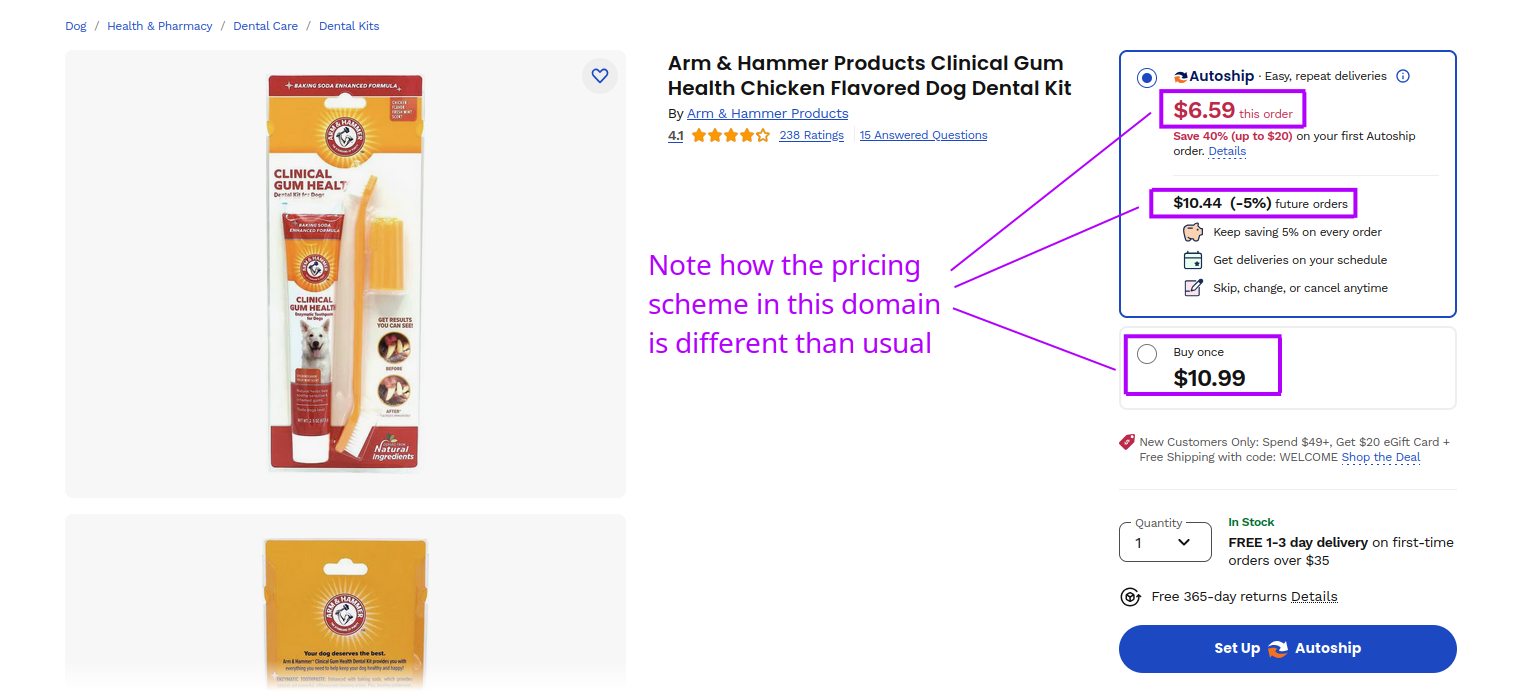

➡️ What data would be extracted when using the Standard Schema for Product?

Let's check it out

In [ ]:
url = "https://www.chewy.com/arm-hammer-products-clinical-gum/dp/54363"
response = await client.get(
    {
        "url": url,
        "browserHtml": True,
        "product": True,
        "productOptions": {
            "extractFrom": "browserHtml",
        }
    }
)

print(json.dumps(response['product'], ensure_ascii=False, indent=4)[:300] + " ... ")

{
    "name": "Arm & Hammer Products Clinical Gum Health Chicken Flavored Dog Dental Kit",
    "price": "6.59",
    "currency": "USD",
    "currencyRaw": "$",
    "regularPrice": "10.99",
    "availability": "InStock",
    "sku": "54363",
    "gtin": [
        {
            "type": "upc",
           ... 


➡️ **But what if we wanted specifically to extract the three price cases?**

That's when extraction using LLMs can be handy.

We can specify in a custom schema the data we want to extract, and via Natural Language the system understands what we want to extract and generates the extraction.

📝 Did you know that?

_**Extraction with LLMs** is a unique feature of the Zyte API and Scrapy Cloud that uses an LLM fine-tuned by Zyte. This LLM has been specifically fine-tuned for data extraction from the web._

➡️ Let's see how this would be done in Zyte API


In [ ]:
response = await client.get(
    {
        "url": url,
        "browserHtml": True,
        "product": True,
        "productOptions": {
            "extractFrom": "browserHtml",
        },
        "customAttributes": {
            "price": {
                "type": "object",
                "description": "Analysis and values of the different pricing options to purchase the product",
                "properties": {
                    "analysis": {
                        "type": "string",
                        "description": "Analyze all the different price options to purchase the product shown in the page."
                    },
                    "subscriptionPriceNow": {
                        "type": "number",
                        "description": "price for the product when bought through a subscription or special service, such as repeating deliveries. In particular, the price of the current purchase"
                    },
                    "subscriptionPriceFuture": {
                        "type": "number",
                        "description": "price for the product when bought through a subscription or special service, such as repeating deliveries. In particular, the price of future purchases"
                    },
                    "priceOneTimePurchase": {
                        "type": "number",
                        "description": "price for the product when bought through a one-time purchase."
                    }
                }
            }
        }
    }
)

In [ ]:
# Check the result of the LLM extraction
print(json.dumps(response['customAttributes'], ensure_ascii=False, indent=4))

{
    "values": {
        "price": {
            "analysis": "The product has multiple pricing options. The first time Autoship price is $6.59, which is a discounted price for the first order. The regular Autoship price is $10.44, which is a 5% discount from the one-time purchase price of $10.99. Additionally, there's a mention of a $20 eGift card for new customers who spend $49+ on their first order, but this is not a direct price reduction for the product itself.",
            "subscriptionPriceNow": 6.59,
            "subscriptionPriceFuture": 10.44,
            "priceOneTimePurchase": 10.99
        }
    },
    "metadata": {
        "inputTokens": 4630,
        "outputTokens": 146,
        "textInputTokens": 4275,
        "maxInputTokens": 19674,
        "excludedPIIAttributes": []
    }
}


# Extracting long values with LLMs in an efficient way

❓ Sometimes, there's data to extract whose value is very long, which is inefficient to be generated by an LLM. Some examples are product descriptions, article bodies, etc.

**Example**: Imagine we want to extract the article body, the author info, and the urls to related articles appearing in this news web page:



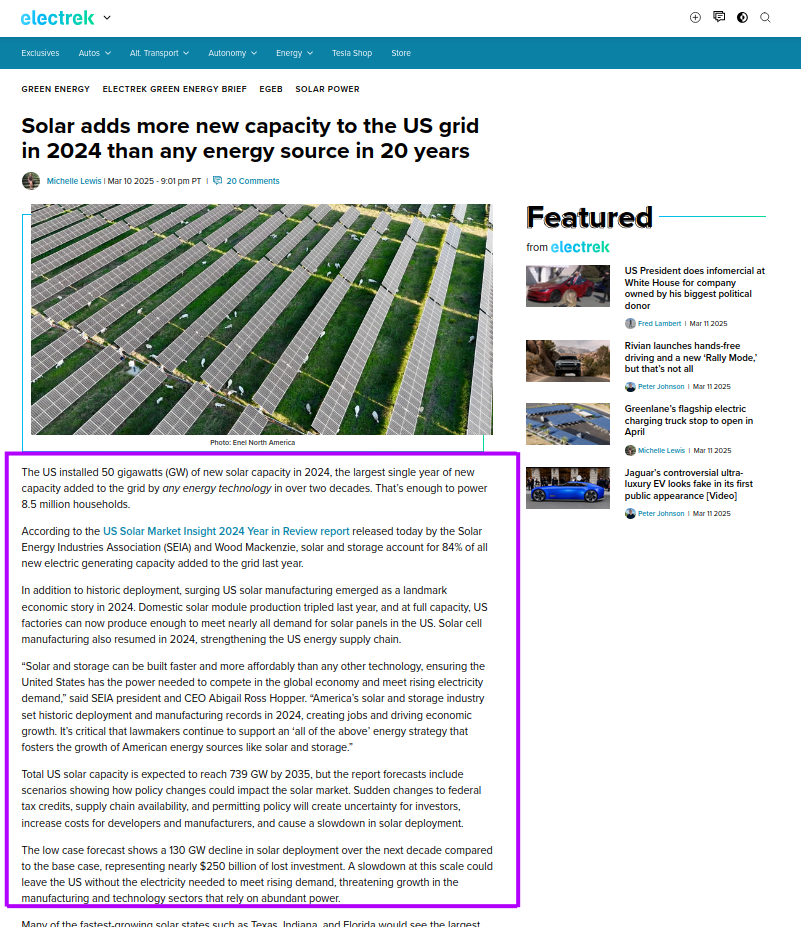


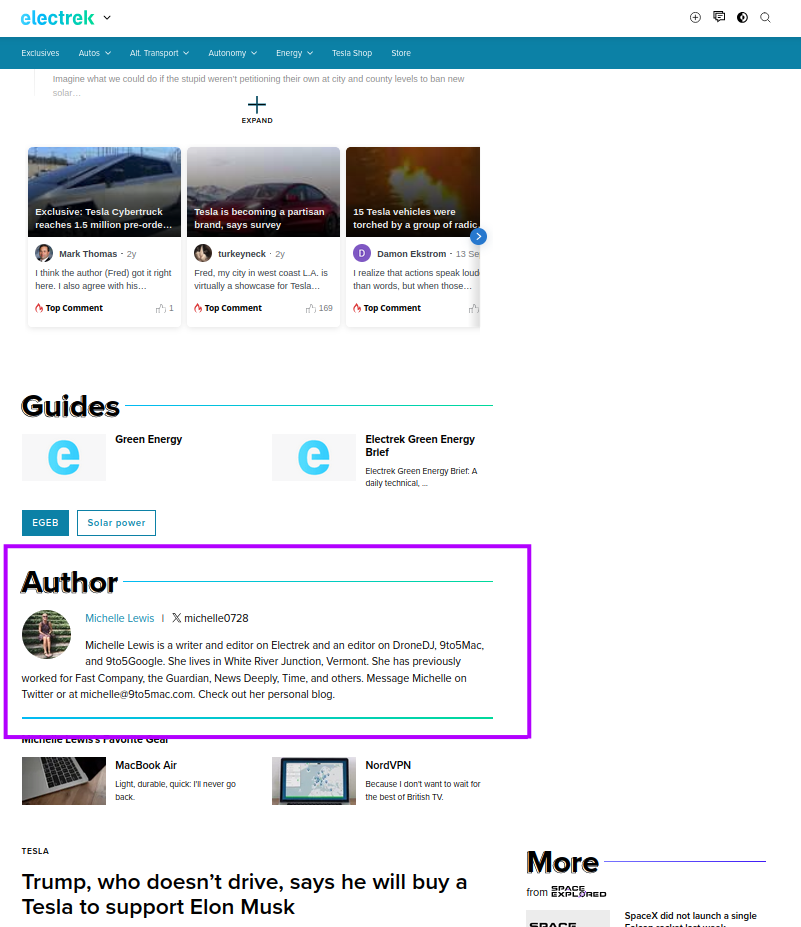


➡️ This would cost a lot of tokens to generate, and therefore it would be more expensive.

💡 **Solution**: Reference the HTML elements and let the LLM select the relevant references.

With this way, we can still extract fields with a lot of information in a cheap way, using a few tokens.

For this particular use case, we have extended the LLM usage for when the extraction has to be done from HTML elements, referencing the HTML elements directly.

We can indicate in Zyte API that we want to run this kind of extraction for a particular attribute in the custom schema.

In that case, internally, Zyte API operates by annotating the HTML first and then **generating with the LLM only a reference** to the relevant HTML node(s) through these annotations.

Since the LLM only generates a reference, **it uses very few output tokens regardless of the amount of text to be extracted**, which is much cheaper than re-generating e.g. the whole article body.


➡️ Let's see how to do this in Zyte API

In [ ]:
url = "https://electrek.co/2025/03/10/solar-new-capacity-us-grid-2024/"

response = await client.get(
    {
        "url": url,
        "browserHtml": True,
        "article": True,
        "articleOptions": {
            "extractFrom": "browserHtml",
        },
        "customAttributes": {
            "articleBody": {
                "type": "string",
                "description": "the body of the article containing the article text. Include as few non-article-body elements as possible, but don't miss any of the article's text",
                "format": "html"  # This is how we specify "extract internally as a reference to the html and don't generate the whole output"
            },
            "authorInfo": {
                "type": "string",
                "description": "all the info of the author that wrote the article",
                "format": "html-text"  # We can also indicate to extract only a reference, but to return the text of the html instead of the html
            },
            "relatedArticles": {
                "type": "array",
                "description": "the links to related/other articles in the page",
                "items": {
                    "type": "string",
                    "description": "the links to related/other articles in the page",
                    "format": "uri"  # We can also indicate to extract references to HTML attributes that contain links
                }
            }
        }
    }
)

### Notice how the output is just a few tokens

In [ ]:
response['customAttributes']['metadata']

{'inputTokens': 4937,
 'outputTokens': 52,
 'textInputTokens': 4623,
 'maxInputTokens': 19154,
 'excludedPIIAttributes': []}

### `authorInfo`

In [ ]:
print(response['customAttributes']['values']['authorInfo'])

Michelle Lewis michelle0728

Michelle Lewis is a writer and editor on Electrek and an editor on DroneDJ, 9to5Mac, and 9to5Google. She lives in White River Junction, Vermont. She has previously worked for Fast Company, the Guardian, News Deeply, Time, and others. Message Michelle on Twitter or at michelle@9to5mac.com. Check out her personal blog.


### `relatedArticles`

In [ ]:
for related_article_url in response['customAttributes']['values']['relatedArticles']:
  print(related_article_url)

https://electrek.co/2025/03/19/tesla-vandalism-trump-and-ag-claim-someone-coordinate-and-fund-them/
https://electrek.co/2025/03/19/thousands-of-tesla-owners-doxxed-the-only-way-to-get-off-the-list-sell-your-car/
https://electrek.co/2025/03/18/tesla-tsla-ride-hailing-permit-california-no-robotaxi-yet/
https://electrek.co/2025/03/18/rwe-texas-wind-ge-vernova/


### `articleBody`

In [ ]:
extracted_html = response['customAttributes']['values']['articleBody']

len(extracted_html)

34039

In [ ]:
import IPython
IPython.display.HTML(extracted_html)

# LLMs in Scrapy Cloud: Extract anything when scraping

- What is shown above is how to use this feature directly through Zyte API
- It can also be used in Scrapy Cloud when scraping a web site, and extract/generate anything you need

Here we will show an example of how to create a **Scrapy Cloud project with LLM extraction** to extract product tags and describe the target audience of the product, and then show an example toy analysis of the results.

# Mini-project: Analyzing the products of a web site via keywords

Imagine you want to do an **analysis of the type of products** a given website sells for market study purposes, to optimize your own prices, to identify niche product categories, to do SEO analysis, or to create a database to perform RAG or some other keyword/semantic search of products.

Some attributes we could extract, among others, could be:
- **Product tags** (`productTags`): a short list of relevant tags that would categorize the product
- **Target audience** (`targetAudience`): an analysis of the target audience that would potentially buy these products


# Extract anything with LLMs in Scrapy Cloud

## 1. Go to https://app.zyte.com/ and create an account

**On sign-up, you receive a free $5 trial** which is more than enough to run this tutorial (or your own version of it) for free.




## 2. Go to Scrapy Cloud projects > Create a project that uses the new Zyte's AI-powered spiders:

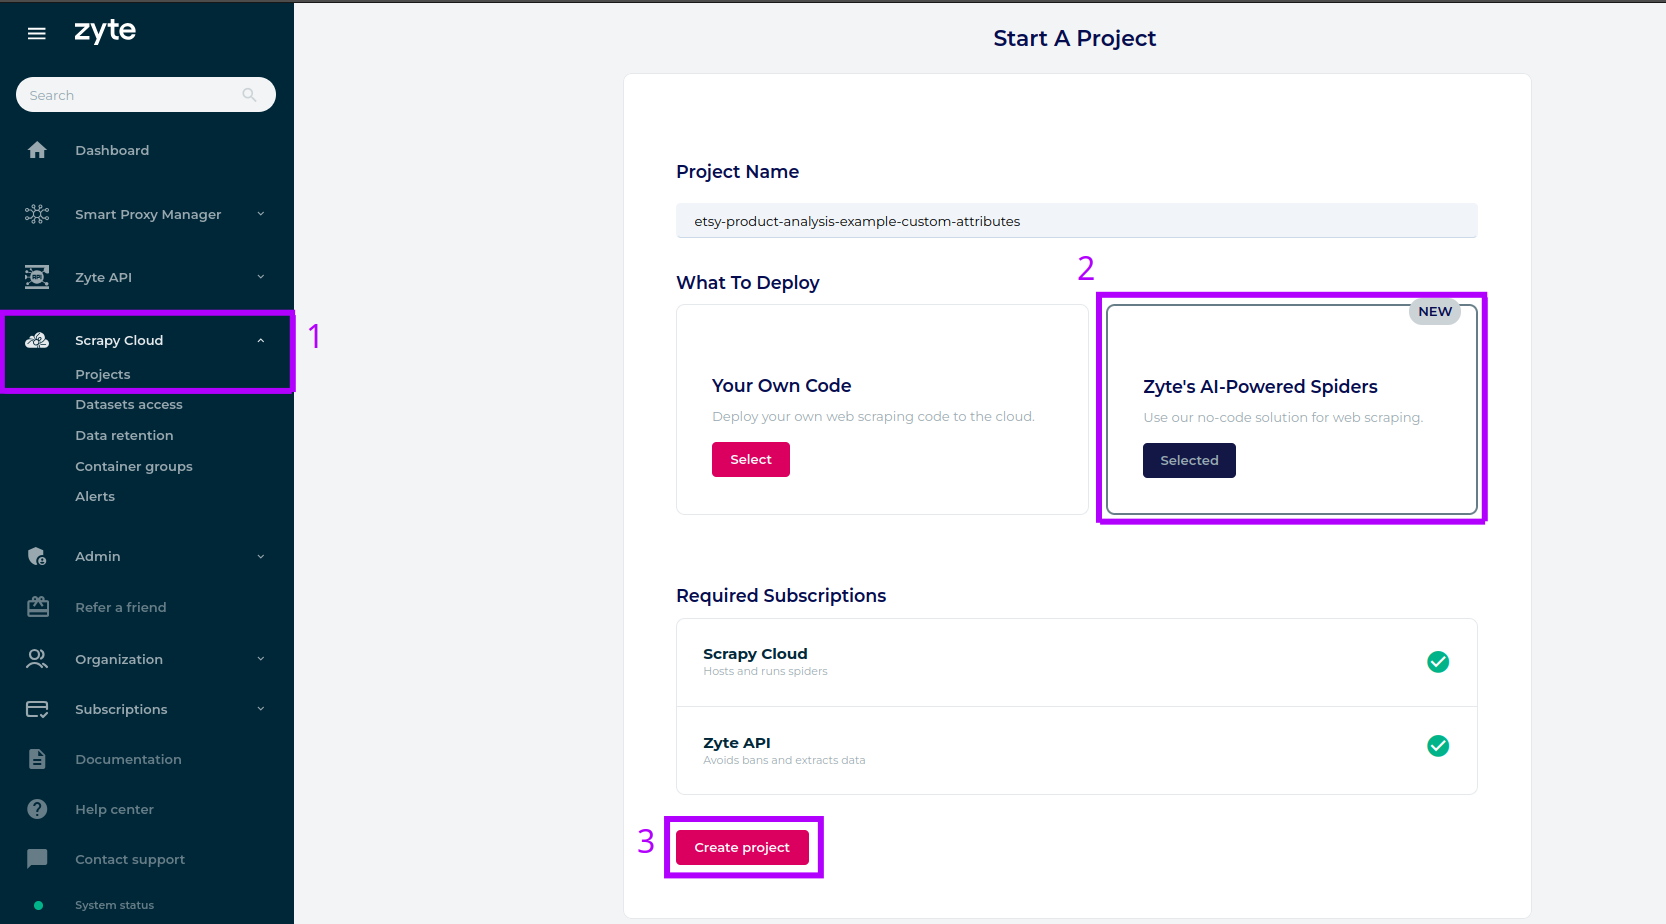



## 3. Create the Spider and configure it as follows, creating also the two custom attributes

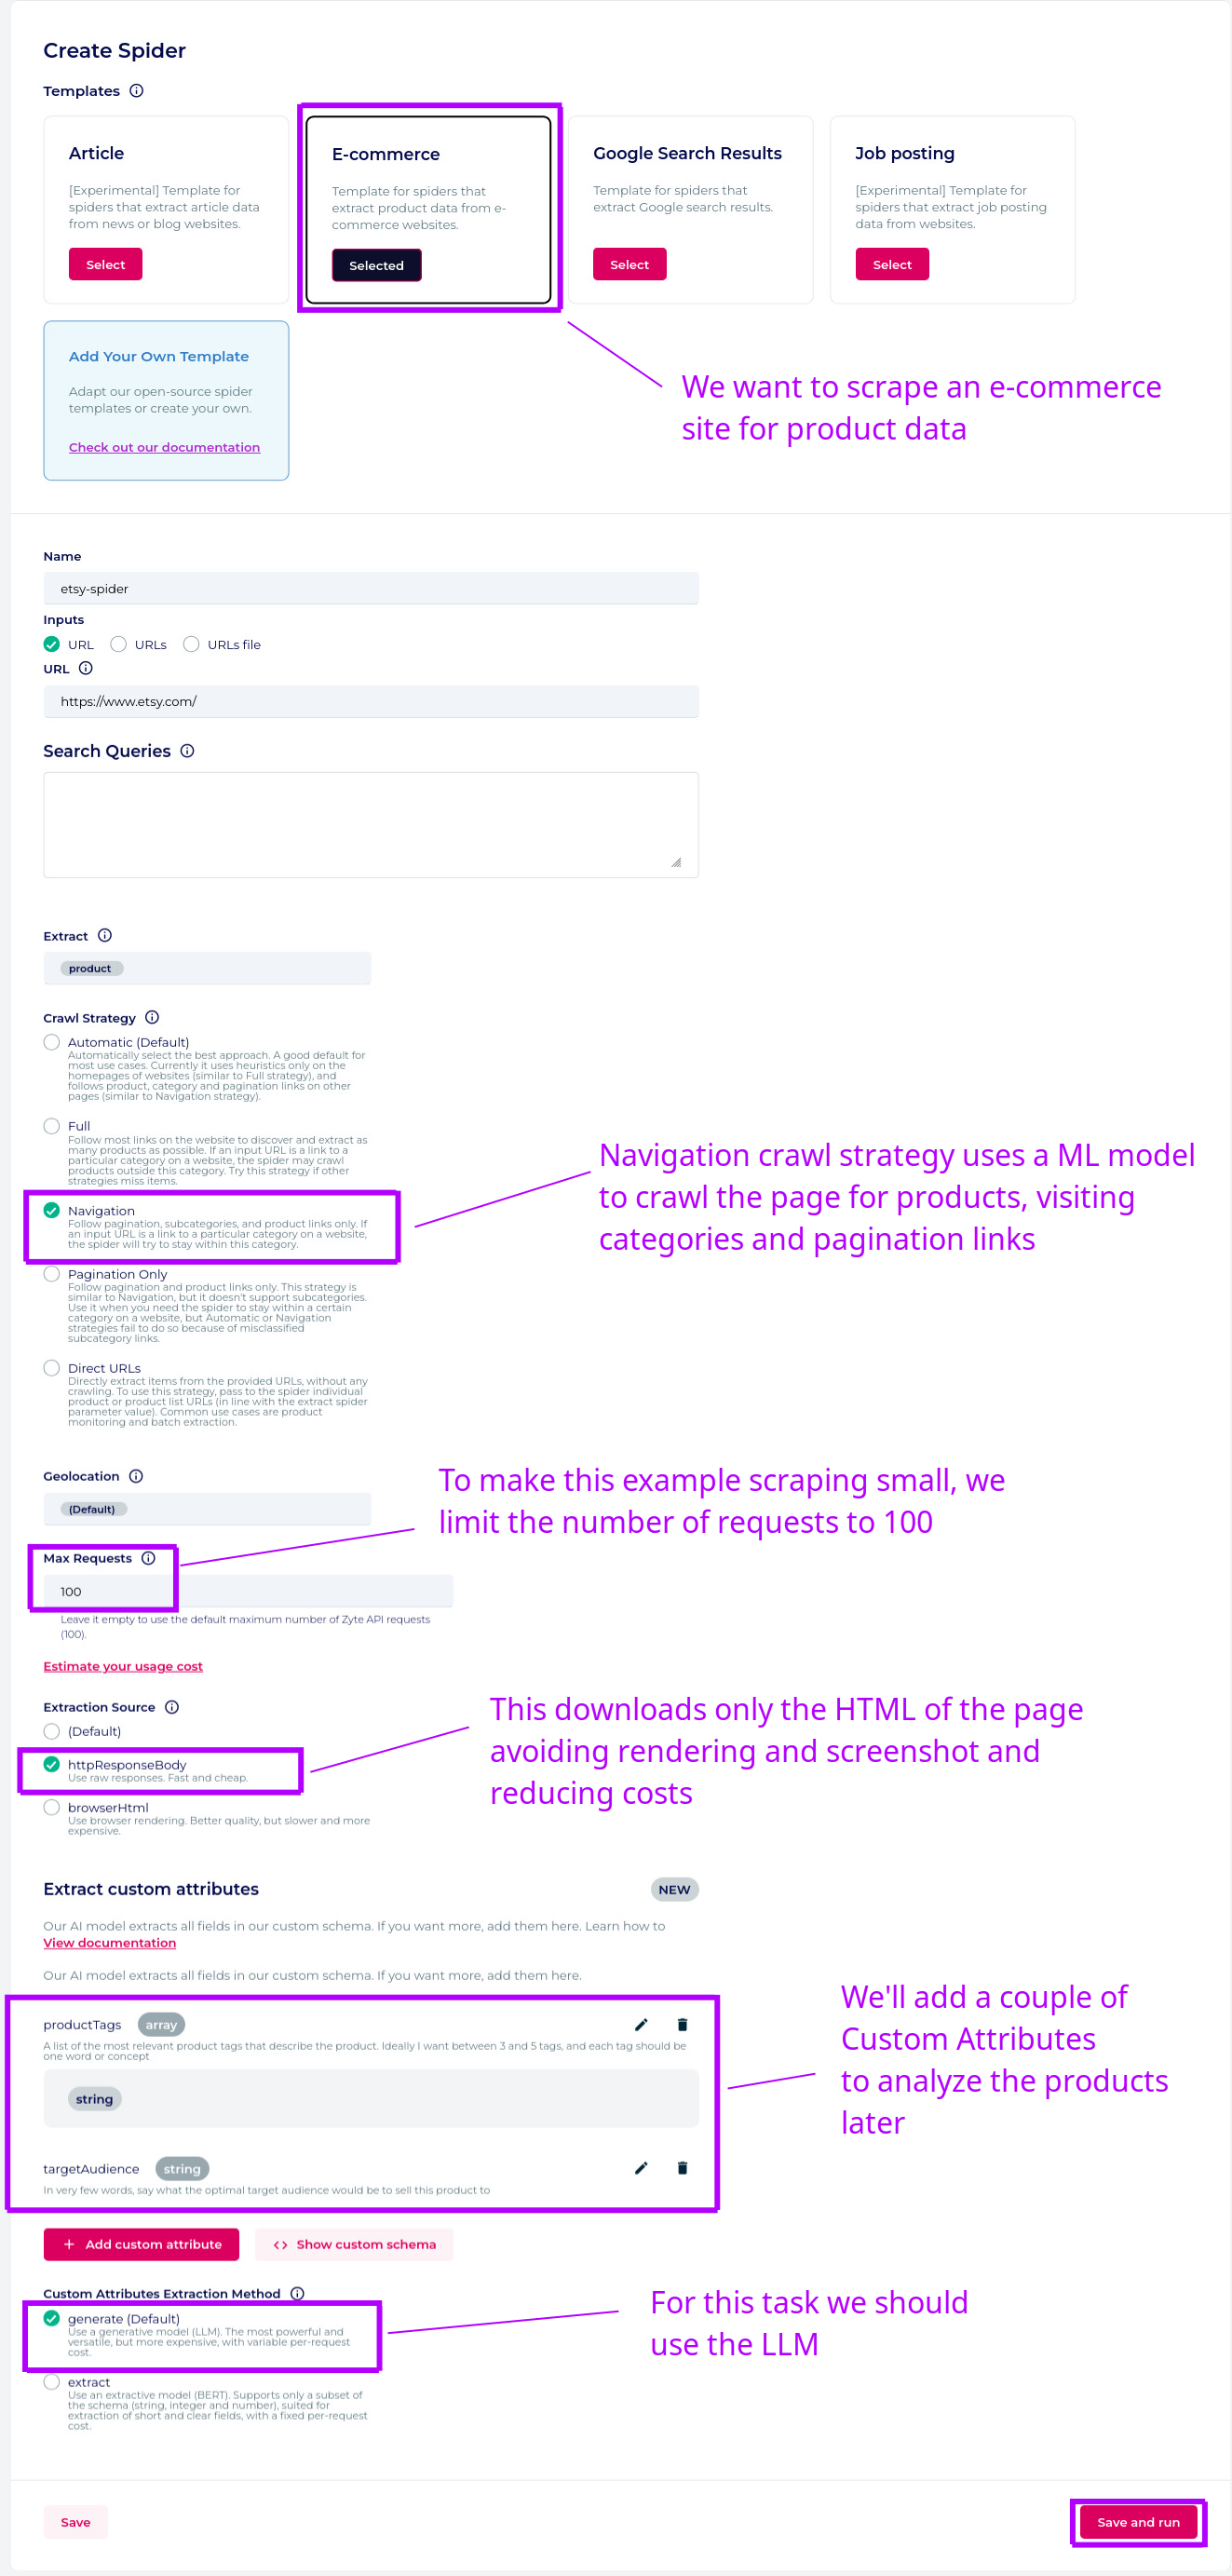



### 3.1. *(window to add custom attributes)*

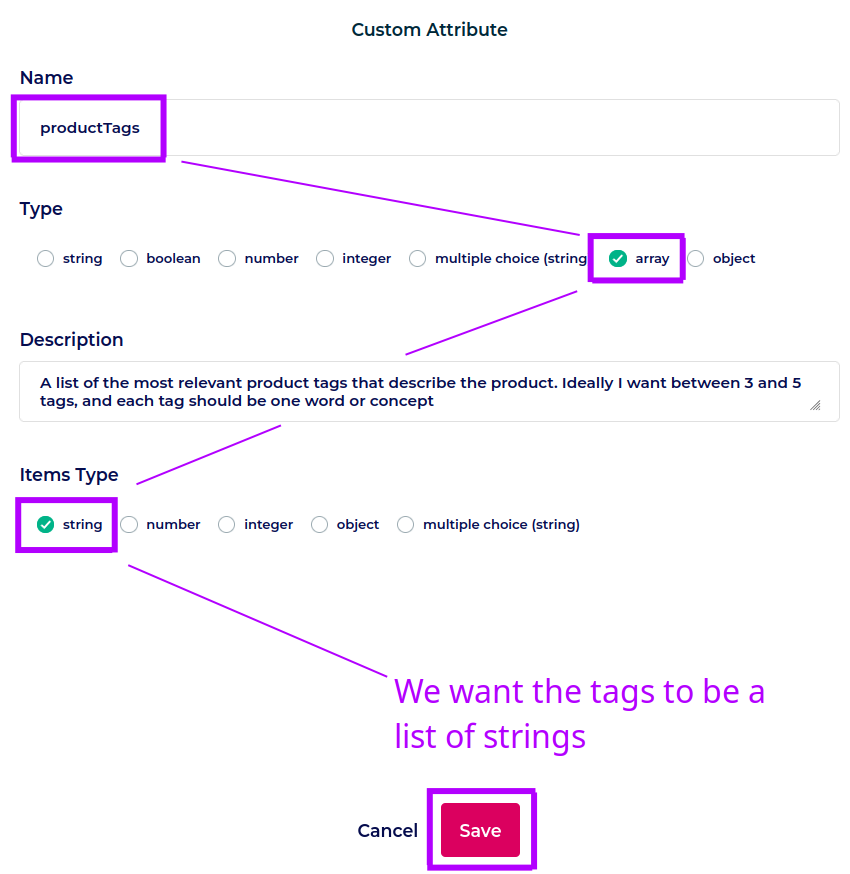![image.png]()

## 4. Result of the spider

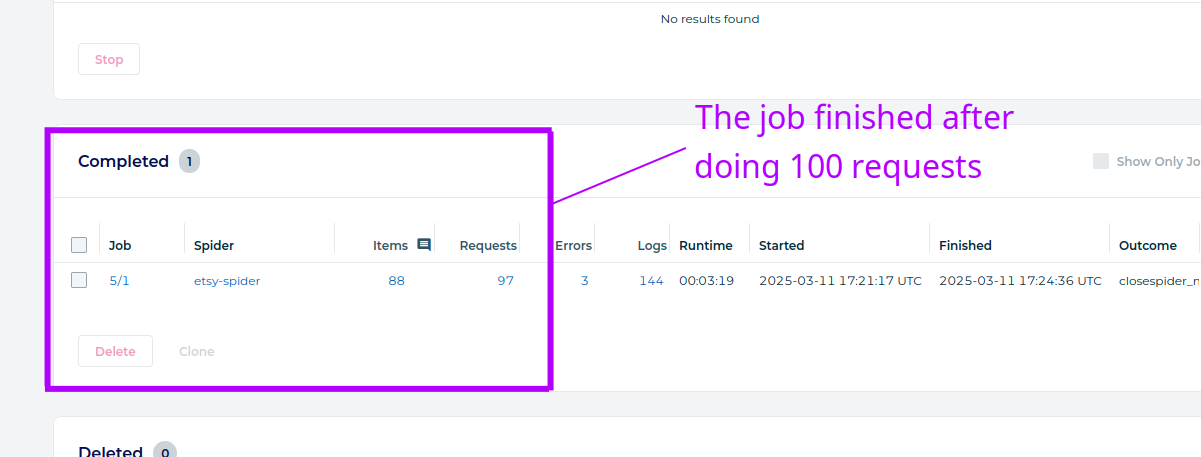

## 5. Download json with the result of the extractions

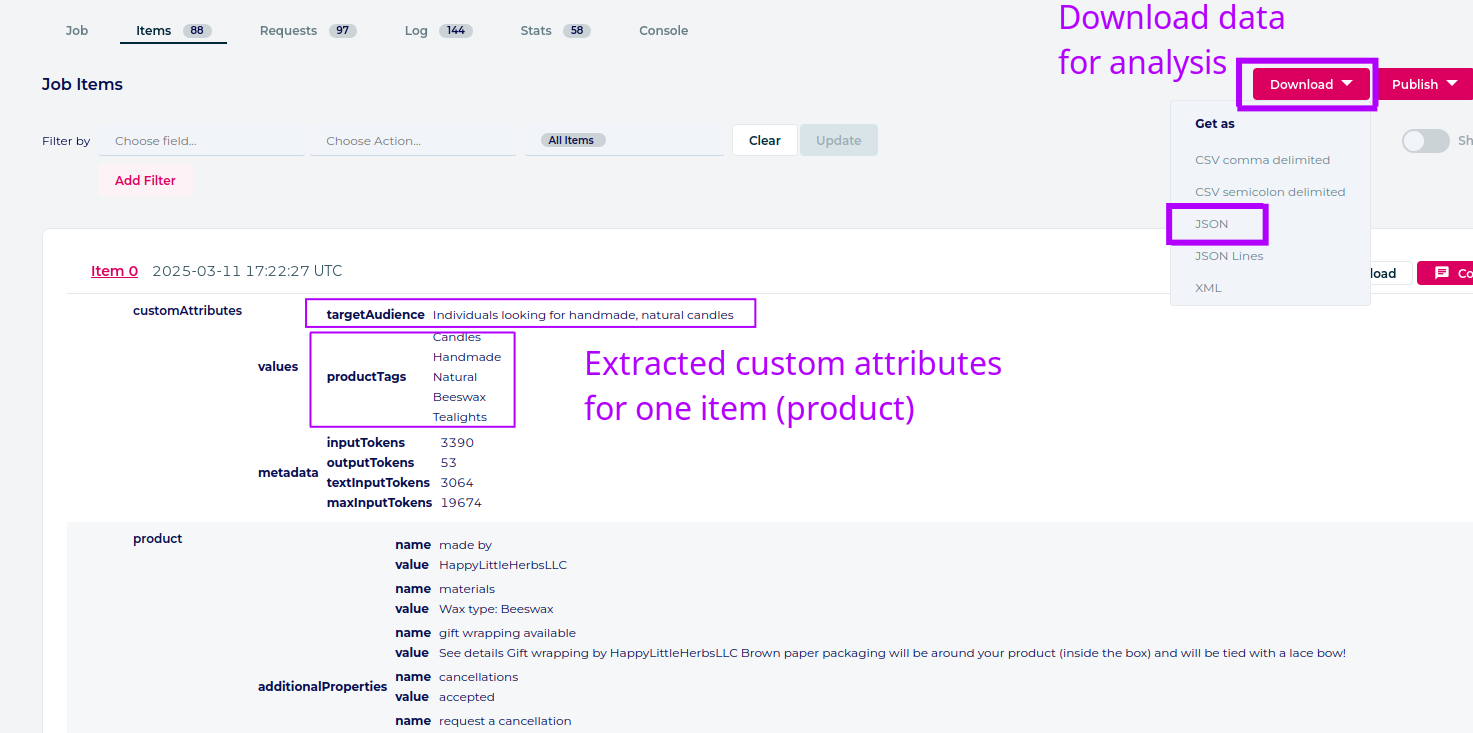

## Using the data

In [ ]:
#@title Upload Data json to Notebook
from google.colab import files

uploaded = files.upload()
print("Uploaded files:", list(uploaded.keys()))

Saving items_books_1.json to items_books_1 (1).json
Uploaded files: ['items_books_1 (1).json']


In [ ]:
#@title Show data
import json
import pandas as pd
import matplotlib.pyplot as plt
import re
from wordcloud import WordCloud

# NLP preprocessing libraries
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Install and import the SentenceTransformer
!pip install -q sentence-transformers
from sentence_transformers import SentenceTransformer, util

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# ---------------------------
# Load and prepare the data
# ---------------------------
# Use the first uploaded file (ensure you've run a cell with files.upload())
filename = list(uploaded.keys())[0]
with open(filename, 'r') as f:
    data = json.load(f)

# Flatten JSON structure and rename fields:
#   - URL from "product.url"
#   - "productTags" and "targetAudience" from "customAttributes.values"
df = pd.json_normalize(data)
df = df.rename(columns={
    'product.url': 'url',
    'customAttributes.values.productTags': 'productTags',
    'customAttributes.values.targetAudience': 'targetAudience'
})
df = df[['url', 'productTags', 'targetAudience']]
df

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


url  \
0   https://books.toscrape.com/catalogue/scott-pil...   
1   https://books.toscrape.com/catalogue/libertari...   
2   https://books.toscrape.com/catalogue/starving-...   
3   https://books.toscrape.com/catalogue/the-requi...   
4   https://books.toscrape.com/catalogue/sharp-obj...   
..                                                ...   
90  https://books.toscrape.com/catalogue/lumberjan...   
91  https://books.toscrape.com/catalogue/political...   
92  https://books.toscrape.com/catalogue/orange-th...   
93  https://books.toscrape.com/catalogue/in-the-co...   
94  https://books.toscrape.com/catalogue/mama-trie...   

                                          productTags  \
0         [Comic, Book, Scott Pilgrim, Graphic Novel]   
1       [Libertarianism, Philosophy, Politics, Books]   
2   [Romance, Historical, Fiction, Triangular Trad...   
3   [Thriller, Asylum, Psychological, Mystery, Hor...   
4   [Psychological, Thriller, Mystery, Fiction, Cr...   
..                                                ...   
90           [Comic, Book, Adventure, Fantasy, Girls]   
91            [Politics, History, Scandals, American]   
92  [Science fiction, Romance, Mystery, Young adul...   
93    [Memoir, Undocumented, Immigration, Resilience]   
94                 [Vegan, Italian, Cooking, Recipes]   

                                       targetAudience  
0                       Young adults, comic book fans  
1      Individuals interested in political philosophy  
2                                     Romance readers  
3   Fans of psychological thrillers and asylum set...  
4            Adult readers of psychological thrillers  
..                                                ...  
90                      Young adults, comic book fans  
91                History buffs, politics enthusiasts  
92          Young adult readers, science fiction fans  
93  Undocumented immigrants, their families, and s...  
94               Vegans interested in Italian cooking  

[95 rows x 3 columns]

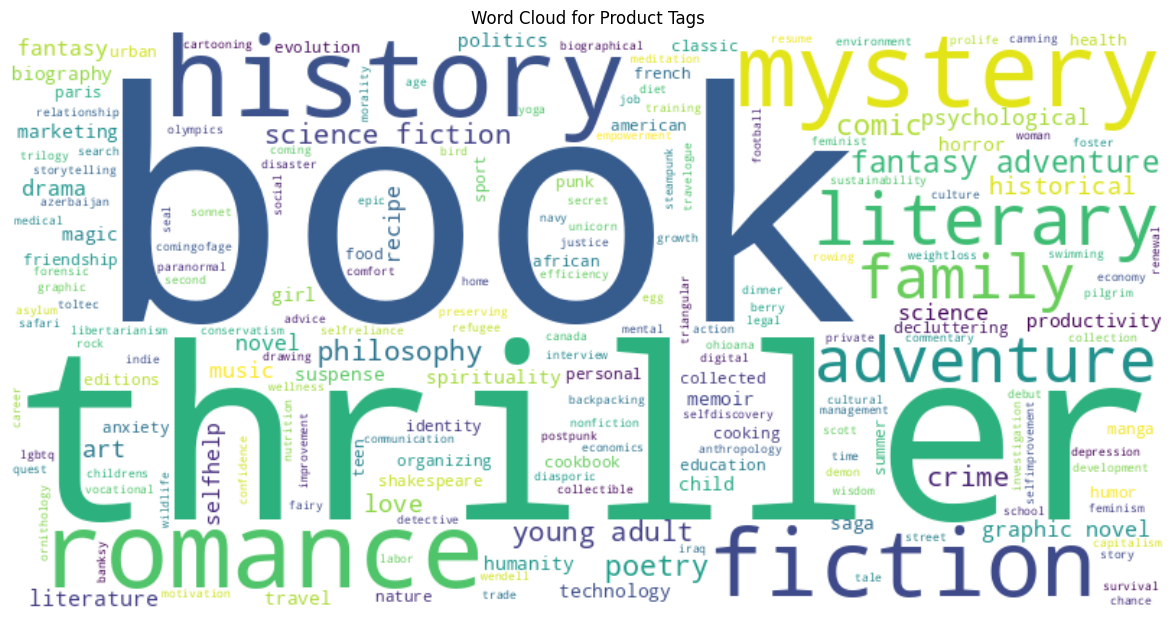

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
##############################################
# Word Cloud for Product Tags
##############################################
def preprocess_tag(tag):
    # Lowercase, remove punctuation, and lemmatize (as noun)
    tag = re.sub(r'[^\w\s]', '', tag.lower())
    return lemmatizer.lemmatize(tag, pos='n')

def process_tags(tags):
    if isinstance(tags, list):
        return [preprocess_tag(t) for t in tags]
    elif isinstance(tags, str):
        tokens = tags.split()
        return [preprocess_tag(t) for t in tokens]
    else:
        return []

# Preprocess and flatten tags
df['tags_tokens'] = df['productTags'].apply(process_tags)
all_tags_tokens = [token for tokens in df['tags_tokens'] for token in tokens]

# Generate and display the word cloud
tags_text = " ".join(all_tags_tokens)
wordcloud_tags = WordCloud(width=800, height=400, background_color='white').generate(tags_text)
plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud_tags, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Product Tags")
plt.show()

##############################################
# Semantic Indexing of Target Audience using Sentence Embeddings
##############################################
def preprocess_target(text):
    # Convert text to string, lowercase, remove punctuation, tokenize, remove stopwords, and lemmatize
    text = re.sub(r'[^\w\s]', '', str(text).lower())
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(t, pos='n') for t in tokens if t not in stop_words]
    return " ".join(tokens)

# Clean target audience texts
df['target_clean'] = df['targetAudience'].apply(preprocess_target)

# Load the pre-trained SentenceTransformer model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Compute embeddings for all target audience texts
target_embeddings = model.encode(df['target_clean'].tolist(), convert_to_tensor=True)




In [ ]:
query_target_audience = "cooks"

In [ ]:
query = query_target_audience
query_clean = preprocess_target(query)
query_embedding = model.encode(query_clean, convert_to_tensor=True)

# Compute dot product similarities between the query embedding and target embeddings
# (Note: Dot product is used here; if embeddings are not normalized, the dot product differs from cosine similarity)
dot_products = util.dot_score(query_embedding, target_embeddings)[0].cpu().numpy()

# Add similarity scores to the dataframe
df['similarity'] = dot_products

# Display the top 10 matches for the query
top_matches = df.sort_values(by='similarity', ascending=False).head(10)
print("Top 10 matches for query:", query)
display(top_matches[['url', 'targetAudience', 'similarity']])

Top 10 matches for query: cooks


url  \
51  https://books.toscrape.com/catalogue/the-pione...   
84  https://books.toscrape.com/catalogue/my-paris-...   
23  https://books.toscrape.com/catalogue/foolproof...   
94  https://books.toscrape.com/catalogue/mama-trie...   
81  https://books.toscrape.com/catalogue/online-ma...   
67  https://books.toscrape.com/catalogue/the-ineff...   
8   https://books.toscrape.com/catalogue/a-light-i...   
31  https://books.toscrape.com/catalogue/the-five-...   
22  https://books.toscrape.com/catalogue/birdsong-...   
47  https://books.toscrape.com/catalogue/throwing-...   

                                   targetAudience  similarity  
51                           Home cooks, families    0.610448  
84            Foodies, French cuisine enthusiasts    0.438217  
23                 Home canners, food enthusiasts    0.408600  
94           Vegans interested in Italian cooking    0.355704  
81                               Authors, Writers    0.313424  
67                          Working professionals    0.251372  
8                                Children, Adults    0.249114  
31                                        Couples    0.222376  
22                              Children, parents    0.221596  
47  Academics, Tech Enthusiasts, Business Leaders    0.216741